In [41]:
import pandas as pd
import requests
import tarfile
import regex as re
import string
import spacy
#import torch

from wordcloud import WordCloud
from textwrap import wrap
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

import nltk
import json
from collections import Counter

In [11]:
#check if MovieSummaries.tar.gz exists, download and decompress
try:
    open('MovieSummaries.tar.gz')
except FileNotFoundError:
    print("Downloading MovieSummaries.tar.gz, decompressing, and saving to ./Data")
    url = 'http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
    r = requests.get(url)
    with open('MovieSummaries.tar.gz', 'wb') as f:
        f.write(r.content)
    # decompress downloaded data
    with tarfile.open('MovieSummaries.tar.gz') as f:
        f.extractall('./Data')
        

# Data

## plot_summaries.txt.gz [29 M] 

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.


# Metadata

## movie.metadata.tsv.gz [3.4 M]

Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

## character.metadata.tsv.gz [14 M]

Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID


# Test data

## tvtropes.clusters.txt

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

## name.clusters.txt


970 unique character names used in at least two different movies, along with 2,666 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.



In [3]:
# read data
# some files are saved as .txt but all files are in tsv-format (tab separated)
df_character_metadata = pd.read_csv('Data/MovieSummaries/character.metadata.tsv', delimiter='\t', header=None)
df_movie_metadata = pd.read_csv('Data/MovieSummaries/movie.metadata.tsv', delimiter='\t', header=None)
df_name_cluster = pd.read_csv('Data/MovieSummaries/name.clusters.txt', delimiter='\t', header=None)
df_plot_summary = pd.read_csv('Data/MovieSummaries/plot_summaries.txt', delimiter='\t', header=None)
df_tvtrope_cluster = pd.read_csv('Data/MovieSummaries/tvtropes.clusters.txt', delimiter='\t', header=None)

In [13]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    
    # Remove extra spaces
    text = re.sub(r' +', ' ', text)
    
    return text

In [14]:
df_plot_summary[1] = df_plot_summary[1].apply(preprocess_text)

In [15]:
# try if cuda is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(0))
    import spacy_transformers
    spacy.require_gpu() #or spacy.prefer_gpu()
else:
    device = torch.device('cpu')  


NVIDIA GeForce RTX 3090


In [16]:
#test if spacy en_core_web_xx exists, if not download it
#English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.
#https://spacy.io/models/en

try:
    lemmatizer = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
except:
    print('Downloading en_core_web_sm')
    !python -m spacy download en_core_web_sm
    lemmatizer = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    

Using GPU


In [17]:
# Lemmatization with stopwords removal
df_plot_summary[1] = df_plot_summary[1].apply(lambda x: ' '.join([token.lemma_ for token in list(lemmatizer(x)) if (token.is_stop==False)]))

In [18]:
# save the preprocessed data
df_plot_summary.to_csv('Data/MovieSummaries/plot_summaries_trf.csv')

## EDA

In [10]:
df_plot_summary = pd.read_csv('Data/MovieSummaries/plot_summaries_trf.csv').iloc[: , 1:]

In [11]:
df_plot_summary.head()

,0,1
0,23890098,shlykov hardworking taxi driver lyosha saxopho...
1,31186339,nation panem consist wealthy capitol poor dist...
2,20663735,poovalli induchoodan sentence year prison life...
3,2231378,lemon drop kid new york city swindler illegall...
4,595909,seventhday adventist church pastor michael cha...


In [12]:
df_plot_summary

,0,1
0,23890098,shlykov hardworking taxi driver lyosha saxopho...
1,31186339,nation panem consist wealthy capitol poor dist...
2,20663735,poovalli induchoodan sentence year prison life...
3,2231378,lemon drop kid new york city swindler illegall...
4,595909,seventhday adventist church pastor michael cha...
...,...,...
42298,34808485,story reema young muslim schoolgirl malabar lo...
42299,1096473,hollywood director leo andreyev look photograp...
42300,35102018,american luthier focus randy parson ’ transfor...
42301,8628195,abdur rehman khan middleage dry fruit seller a...


In [14]:
# create document term matrix
cv = CountVectorizer(analyzer='word')
data = cv.fit_transform(df_plot_summary['1'])  # returns sparse DTM

In [15]:
# Extract one row (film) from the DTM and expand to all rows (sparse -> dense)
df_dtm = pd.DataFrame(data.getrow(1).toarray(), columns=cv.get_feature_names_out())

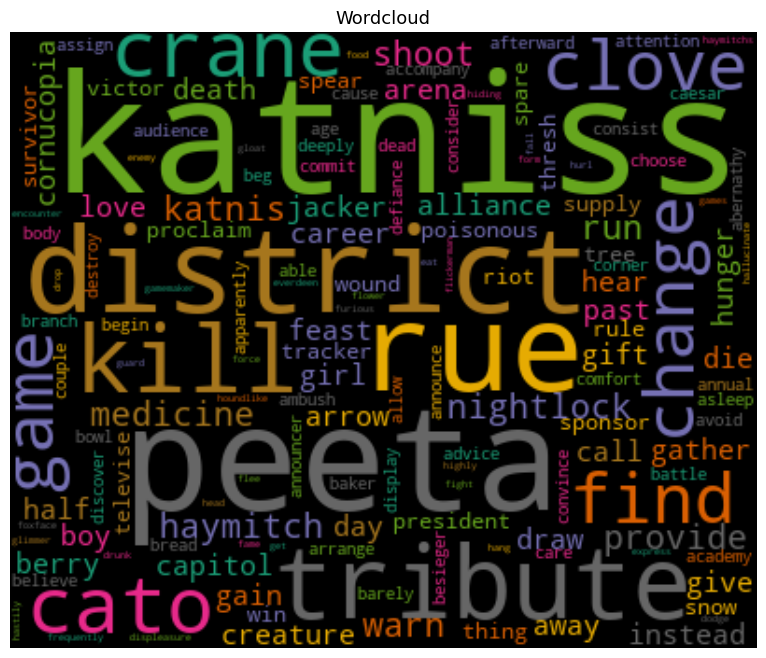

In [17]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text


# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()


generate_wordcloud(df_dtm.iloc[0], 'Wordcloud')

<Axes: >

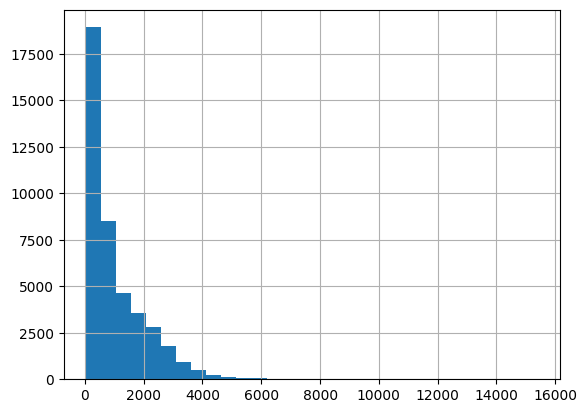

In [23]:
df_plot_summary['1'].str.len().hist(bins=30)

<Axes: >

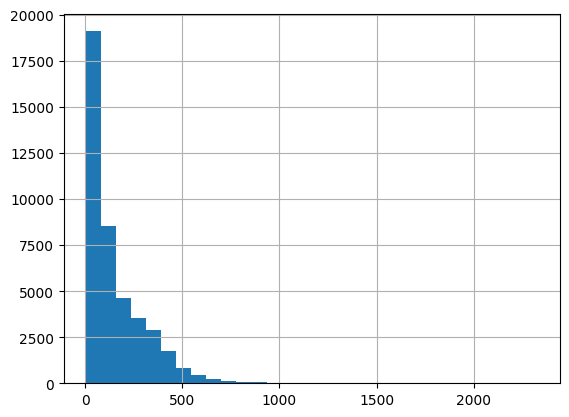

In [25]:
df_plot_summary['1'].str.split().map(lambda x: len(x)).hist(bins=30)

In [39]:
genre_df = df_movie_metadata[[0,2,8]]
genre_df['genre'] = genre_df[8].apply(lambda x: list(json.loads(x).values()))
genre_df['genre_id'] = genre_df[8].apply(lambda x: list(json.loads(x).keys()))

genre_df.columns = ['movie_id','title','genre_json','genre','genre_id']
genre_df.head()

C:\Users\anna-\AppData\Local\Temp\ipykernel_18740\3618410631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['genre'] = genre_df[8].apply(lambda x: list(json.loads(x).values()))
C:\Users\anna-\AppData\Local\Temp\ipykernel_18740\3618410631.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['genre_id'] = genre_df[8].apply(lambda x: list(json.loads(x).keys()))


,movie_id,title,genre_json,genre,genre_id
0,975900,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","[Thriller, Science Fiction, Horror, Adventure,...","[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...","[Mystery, Biographical film, Drama, Crime Drama]","[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]"
2,28463795,Brun bitter,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Crime Fiction, Drama]","[/m/0lsxr, /m/07s9rl0]"
3,9363483,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","[Thriller, Erotic thriller, Psychological thri...","[/m/01jfsb, /m/0glj9q, /m/09blyk]"
4,261236,A Woman in Flames,"{""/m/07s9rl0"": ""Drama""}",[Drama],[/m/07s9rl0]


In [52]:
flattened_list = [item for sublist in genre_df['genre'] for item in sublist]

# Step 2: Count the occurrences of each element
element_counts = Counter(flattened_list)
print(len(element_counts))
sorted(element_counts.items(), key=lambda x:x[1], reverse=True)

363


[('Drama', 34007),
 ('Comedy', 16349),
 ('Romance Film', 10234),
 ('Black-and-white', 9094),
 ('Action', 8798),
 ('Thriller', 8744),
 ('Short Film', 8141),
 ('World cinema', 7155),
 ('Crime Fiction', 6948),
 ('Indie', 6897),
 ('Documentary', 5630),
 ('Horror', 5280),
 ('Silent film', 5250),
 ('Adventure', 4963),
 ('Family Film', 4598),
 ('Action/Adventure', 4561),
 ('Comedy film', 4362),
 ('Musical', 4160),
 ('Animation', 3534),
 ('Romantic drama', 3372),
 ('Mystery', 3195),
 ('Science Fiction', 3052),
 ('Fantasy', 2820),
 ('Romantic comedy', 2680),
 ('War film', 2652),
 ('Japanese Movies', 2322),
 ('Western', 2226),
 ('Crime Thriller', 2122),
 ('Period piece', 1758),
 ('Comedy-drama', 1720),
 ('Film adaptation', 1531),
 ('Chinese Movies', 1525),
 ('Biography', 1392),
 ('Psychological thriller', 1331),
 ('Bollywood', 1321),
 ('Sports', 1206),
 ('Biographical film', 1198),
 ('LGBT', 1163),
 ('Music', 1088),
 ('Family Drama', 1043),
 ('Black comedy', 1025),
 ('Parody', 999),
 ('Televisio